# Starting Kit - Relevance 

# Introduction to Challenge
The RelevAI project, which is in the field of Information Retrieval (IR), focuses on academic literature. It is driven by the need to classify the relevance of papers in the scientific literature, a task that grows harder with large text volumes and diverse topics. The project aims to automate the process of assessing document relevance to specific prompts or queries, which has the potential to save users valuable time and effort.

Traditional methods like text matching and keyword search often miss contextual meaning and word relationships, resulting in inaccurate relevance assessments. Therefore, this challenge proposes users to come up with Artificial Intelligence techniques to improve this task, capturing semantic and contextual aspects of the text to better predict its relevance. The successful development of an effective relevance ranking algorithm can have a significant impact on society. It can enhance literature reviews, accelerate scientific research, expedite breakthroughs in diverse fields, facilitate efficient literature searches, simplify information access, and enhance learning and decision-making processes.

# Introduction to Data
This challenge aims to categorize candidate papers based on their alignment with a given prompt. It is formulated as a supervised learning problem, where the input consists of a prompt along with 4 candidate survey papers, and the desired output are the relevance classes to be assigned to each of these papers. Specifically, label 3 denotes the most relevance, 2 for the second most relevance, 1 for the second least relevance, and 0 for the least relevance. Each paper contains a Title, Abstract, and Related Works sections generated by ChatGPT from citations. The prompts were generated by reverse-engineering using ChatGPT and the most relevant paper as a reference.

### Input
Pairs made out of a prompt + paper (title, abstract and related works). Note: each prompt has 4 different papers with different levels of relevance (most relevant, second most relevant, second least relevant and least relevant). Therefore, each prompt appears in four different instances of the dataset, but with different papers in each row (and therefore different labels representing the relevance level).

### Output
Numeric value indicating the level of relevance of a paper with regard to a prompt:
1. Label 3 indicates the highest relevance (most relevant)
2. Label 2 for the second highest (second most relevant)
3. Label 1 for the second lowest (second least relevant)
4. Label 0 for the lowest relevance (least relevant)e.age.

# Evaluation
Initially, the performance of the models will be evaluated using Kendall’s Tau coefficient, which is further explained down below in this notebook. Therefore, you should prioritize approaches that optimize the Kendall’s Tau coefficient. We also present different metrics in the scoring report, such as accuracy and precision, to give a further idea of how well your model is performing. Those other metrics can be used as tie breakers in case of different approaches with the same Kendall’s Tau coefficient.

# This Starting kit notebook

Now that you have an idea about the scope of the challenge, motivations and objectives behind it, data format and evaluation, you may want to get a first taste of the challenge. This starting kit provides a basic baseline using a small sample of the data so that you may better visualize and understand the date, besides being a great example of how you should generate a zip file to submit in the Codabench website. You may play with it in order to get familiar before you start using your creativity to develop your very own solution!

# Credits
This challenge wouldn't be possible without the hard work of different people involved, so we use this section to acknowledge the responsibles for creating this project.

### Database donors
* Benedictus Kent Rachmat
* KHUONG Thanh Gia Hieu

### Project development team members
* Paulo Henrique Couto
* Nageeta Kumari 
* Quang Phuoc HO

# Getting Started Instructions

Before executing the code, we want you to make sure that you have a required setup to run this starting kit.
1. Make sure you are using python 3.9 version  
2. All the following packages must be installed, to check these you can simply use: pip show [name_of_package]  
    - numpy
    - pandas
    - matplotlib
    - tqdm
    - sentence_transformers
    - sklearn
    - torch
    - ipywidgets
    - wordcloud

If any of these are not installed, simply use: pip install [name_of_package]



***
# Setup
***
`COLAB` determines whether this notebook is running on Google Colab.

In [ ]:
COLAB='google.colab' in str(get_ipython())

In [ ]:
if COLAB:
    # clone github repo
    !git clone https://github.com/ihsaan-ullah/M1-Challenge-Class-2024.git

    # move to the HEP starting kit folder
    %cd M1-Challenge-Class-2024/Relevance/Starting_Kit/

    !pip install -q --upgrade sentence-transformers transformers


***
# Imports
***

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm

from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy.stats import kendalltau
from sklearn.metrics import cohen_kappa_score

import random
import torch
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)


from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

***
# Directories
***

In [4]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"
# Reference data directory to read test labels from
reference_dir = root_dir + "sample_data/"
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

***
# Add directories to path
***

In [5]:
sys.path.append(input_dir)
sys.path.append(reference_dir)
sys.path.append(output_dir)
sys.path.append(program_dir)
sys.path.append(submission_dir)

***
# Data
***
1. Load Data
2. Preprocess data


### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like.

In [ ]:
from transformers import DistilBertTokenizer


class Data():

    def __init__(self):

        self.df = None

        print("==========================================")
        print("Data")
        print("==========================================")

    def load_data(self):
        """
          Loads data from csv file
        """
        print("[*] Loading Data")

        # data file path
        data_file = os.path.join(input_dir, 'relevance_data_5000.csv')

        # read data
        self.df = pd.read_csv(data_file)


    def _text_to_dict(self, text):
        """
        Converts a text string into a dictionary.

        :param text: A string representation of a dictionary.
        :return: A dictionary object if conversion is successful, otherwise {}.
        """
        try:
            return ast.literal_eval(text)
        except:
            return {}  # Return an empty dictionary in case of an error
    
    def _dict_to_paragraphs(self, dictionary):
        """
        Converts a dictionary into a string of paragraphs.

        :param dictionary: A dictionary.
        :return: A string composed of paragraphs based on the dictionary's key-value pairs.
        """
        text = ''
        for i, (k, v) in enumerate(dictionary.items()):
            text += k.capitalize() + '\n' + v + '\n'
        return text

    def _thermometer_encode(self, label, num_classes):
        encoded_label = np.zeros(num_classes - 1)
        encoded_label[:label] = 1

        return encoded_label
  
    def transfrom_data(self):

        print("[*] Transforming Data")

        # Convert to dictionary
        self.df['most_relevant_dict'] = self.df['most_relevant'].apply(self._text_to_dict)
        self.df['second_most_relevant_dict'] = self.df['second_most_relevant'].apply(self._text_to_dict)
        self.df['second_least_relevant_dict'] = self.df['second_least_relevant'].apply(self._text_to_dict)
        self.df['least_relevant_dict'] = self.df['least_relevant'].apply(self._text_to_dict)


        # Convert from dictionary to text
        self.df['most_relevant_text'] = self.df['most_relevant_dict'].apply(self._dict_to_paragraphs)
        self.df['second_most_relevant_text'] = self.df['second_most_relevant_dict'].apply(self._dict_to_paragraphs)
        self.df['second_least_relevant_text'] = self.df['second_least_relevant_dict'].apply(self._dict_to_paragraphs)
        self.df['least_relevant_text'] = self.df['least_relevant_dict'].apply(self._dict_to_paragraphs)

    
    def pad_sequence_to_max_length(self, sequence, padding_value=0):
        """
        this functions pads an input sequence
        """
        padded_sequence = sequence + [padding_value] * (self.max_length - len(sequence))
        return padded_sequence


    def prepare_data(self):

        print("[*] Prepare Data for Training")

        # tokenizer = BertTokenizer.from_pretrained("distillbert-base-uncased")
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        least_relevant_df = pd.DataFrame()
        least_relevant_df['input'] = self.df.apply(lambda row: tokenizer.encode(row['prompt'] + " " + row['least_relevant_text'], truncation=True), axis=1)
        least_relevant_df['label'] = 0
    
        second_least_relevant_df = pd.DataFrame()
        second_least_relevant_df['input'] = self.df.apply(lambda row: tokenizer.encode(row['prompt'] + " " + row['second_least_relevant_text'], truncation=True), axis=1)
        second_least_relevant_df['label'] = 1

        second_most_relevant_df = pd.DataFrame()
        second_most_relevant_df['input'] = self.df.apply(lambda row: tokenizer.encode(row['prompt'] + " " + row['second_most_relevant_text'], truncation=True), axis=1)
        second_most_relevant_df['label'] = 2

        most_relevant_df = pd.DataFrame()
        most_relevant_df['input'] = self.df.apply(lambda row: tokenizer.encode(row['prompt'] + " " + row['most_relevant_text'], truncation=True), axis=1)
        most_relevant_df['label'] = 3

        # combine all 4 dataframes
        concatenated_rows = []
        # Iterate over the rows of the DataFrames and concatenate them row by row
        for index in range(len(most_relevant_df)):
            concatenated_row = pd.concat([most_relevant_df.iloc[[index]], second_most_relevant_df.iloc[[index]], second_least_relevant_df.iloc[[index]], least_relevant_df.iloc[[index]]], ignore_index=True)
            concatenated_rows.append(concatenated_row)

        # Concatenate the list of concatenated rows into a single DataFrame
        tokenized_df = pd.concat(concatenated_rows, ignore_index=True)
    
        tokenized_df['label_onehot'] = tokenized_df['label'].apply(lambda x : self._thermometer_encode(x, 4))

        # pad the sequences
        self.max_length=tokenized_df['input'].apply(len).max()
        tokenized_df['input_padded'] = tokenized_df['input'].apply(lambda x: self.pad_sequence_to_max_length(x))
        X = tokenized_df['input_padded']
        y = tokenized_df['label_onehot']
        grouped_data = [(X[i:i+4], y[i:i+4]) for i in range(0, len(X), 4)]
        np.random.shuffle(grouped_data)
        shuffled_X, shuffled_y = zip(*[(x, label) for group in grouped_data for x, label in zip(group[0], group[1])])

        X = torch.tensor(shuffled_X)
        y = torch.tensor(shuffled_y)

        dataset = TensorDataset(X, y)
        self.train_dataset, self.test_dataset = train_test_split(dataset, test_size=0.2, shuffle=False)

    def get_train_data(self):
        return self.train_dataset
  
    def get_test_data(self):
        return self.test_dataset
  
    def show_random_sample(self):
        random_sample_index = np.random.randint(0, len(self.df))

        print("Prompt:\n", self.df.iloc[random_sample_index]['prompt'], "...\n")
        print("Most Relevant Text:\n", self.df.iloc[random_sample_index]['most_relevant_text'][:300], "...\n")
        print("Second Most Relevant Text:\n", self.df.iloc[random_sample_index]['second_most_relevant_text'][:300], "...\n")
        print("Second Least Relevant Text:\n", self.df.iloc[random_sample_index]['second_least_relevant_text'][:300], "...\n")
        print("Least Relevant Text:\n", self.df.iloc[random_sample_index]['least_relevant_text'][:300], "...\n")

In [7]:
# Initilaize data
data = Data()

Data


In [8]:
# load data
data.load_data()

[*] Loading Data


In [9]:
# transform data
data.transfrom_data()

[*] Transforming Data


In [10]:
# prepare data
data.prepare_data()

[*] Prepare Data for Training


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
# # show random sample from data
data.show_random_sample()

Prompt:
 Write a systematic survey or overview about the impact of blended learning on student and instructor satisfaction and engagement in chemical engineering design courses, focusing on the results of independent interviews with student cohorts, instructor interviews, and data analysis of student satisfaction and engagement surveys. ...

Most Relevant Text:
 Title
STUDENT AND INSTRUCTOR SATISFACTION AND ENGAGEMENT WITH BLENDED LEARNING IN CHEMICAL ENGINEERING DESIGN
Abstract
  
Abstract – The capstone Chemical Engineering Course 
was used to pilot blended learning as part of an ongoing 
digital learning initiative at the University of Alberta. A 
blende ...

Second Most Relevant Text:
 Title
What matters in college? : four critical years revisited
Abstract
From the author of Four Critical Years--a book the Journal of Higher Education called the most cited work in higher education literature--What Matters in College? presents the definitive study of how students change and develop  

In [12]:
# get train test data
train_dataset = data.get_train_data()
test_dataset = data.get_test_data()

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: initializes classifier
- `fit`: gets train data and labels as input to train the classifier
- `predict`: gets test data and outputs predictions made by the trained classifier


In this example code, the `Model` class implements a Gradient Boosting Classifier model. You can find the code in `M1-Challenge-Class-2024/Relevance/Starting_Kit/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

In [13]:
from model import Model

***
# Program
***
**`Ingestion program`** is responsible to run the submission of a participant on Codabench platform. **`Program`** is a simplified version of the **Ingestion Program** to show to participants how it runs a submission.
1. Train a model on train data
2. Predict using Test data

In [14]:
class Program():

    def __init__(self, data):

        # used to keep object of Model class to run the submission
        self.model = None
        # object of Data class used here to get the train and test sets
        self.data = data

        # results
        self.results = []

        print("==========================================")
        print("Program")
        print("==========================================")
    
    def initialize_submission(self):
        print("[*] Initializing Submmited Model")
        self.model = Model()
        

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        train_dataloader = DataLoader(self.data.get_train_data(), batch_size=4, shuffle=True)
        num_epochs = 5
        loss = self.model.fit(train_dataloader, num_epochs)
        return loss


    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        test_dataloader = DataLoader(self.data.get_test_data(), batch_size=4, shuffle=False)
        self.y_test_hat, self.y_test_truth = self.model.predict(test_dataloader)
       

In [15]:
# Intiialize Program
program = Program(data=data)

Program


In [16]:
# Initialize submitted model
program.initialize_submission()

[*] Initializing Submmited Model
[*] - Initializing Classifier


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Call fit method of submitted model
loss = program.fit_submission()

[*] Calling fit method of submitted model
[*] - Training Classifier on the train set


Epoch 1:   0%|          | 0/4000 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Average training loss: 0.2348969229847918


Epoch 2:   0%|          | 0/4000 [00:00<?, ?it/s]

Average training loss: 0.150180697996298


Epoch 3:   0%|          | 0/4000 [00:00<?, ?it/s]

Average training loss: 0.11486587399281424


Epoch 4:   0%|          | 0/4000 [00:00<?, ?it/s]

Average training loss: 0.08341903666270378


Epoch 5:   0%|          | 0/4000 [00:00<?, ?it/s]

Average training loss: 0.06279415182921107


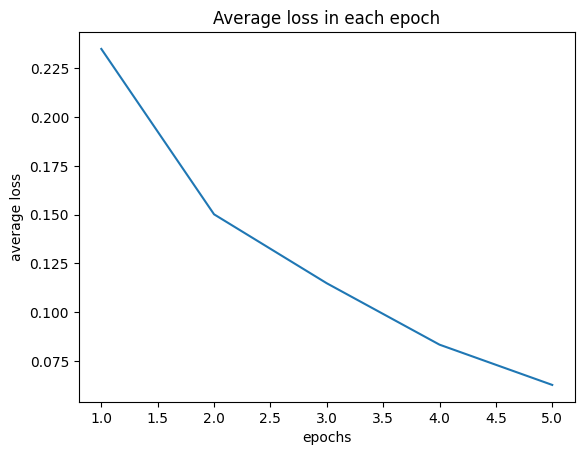

In [20]:
n_epochs = 5 
plt.plot(np.linspace(1, n_epochs, n_epochs), loss)
plt.xlabel("epochs")
plt.ylabel("average loss")
plt.title("Average loss in each epoch")
plt.show()

In [25]:
tau_score = []
class_names = ['least_relevant', 'second_least_relevant', 'second_most_relevant', 'most_relevant']
f1_score = dict()

for class_name in class_names:
    f1_score[class_name] = []

for i in range(n_epochs):
    # Call predict method of submitted model
    program.predict_submission()
    
    true_labels = program.y_test_truth
    predictions = program.y_test_hat
    report = classification_report(true_labels, predictions, output_dict=True, target_names=class_names)
    print(classification_report(true_labels, predictions, output_dict=False, target_names=class_names))

    for class_name in class_names:
        f1_score[class_name].append(report[class_name]['f1-score'])
    k_tau, _ = kendalltau(true_labels, predictions)
    print(f"Kendall's Tau: {k_tau}")
    tau_score.append(k_tau)
    print("------")

[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier
                       precision    recall  f1-score   support

       least_relevant       0.77      0.77      0.77      1000
second_least_relevant       0.74      0.74      0.74      1000
 second_most_relevant       0.95      0.95      0.95      1000
        most_relevant       0.99      0.99      0.99      1000

             accuracy                           0.86      4000
            macro avg       0.86      0.86      0.86      4000
         weighted avg       0.86      0.86      0.86      4000

Kendall's Tau: 0.9046556666666667
------
[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier
                       precision    recall  f1-score   support

       least_relevant       0.78      0.78      0.78      1000
second_least_relevant       0.76      0.76      0.76      1000
 second_most_relevant       0.96      0.96      0.96      1000
     

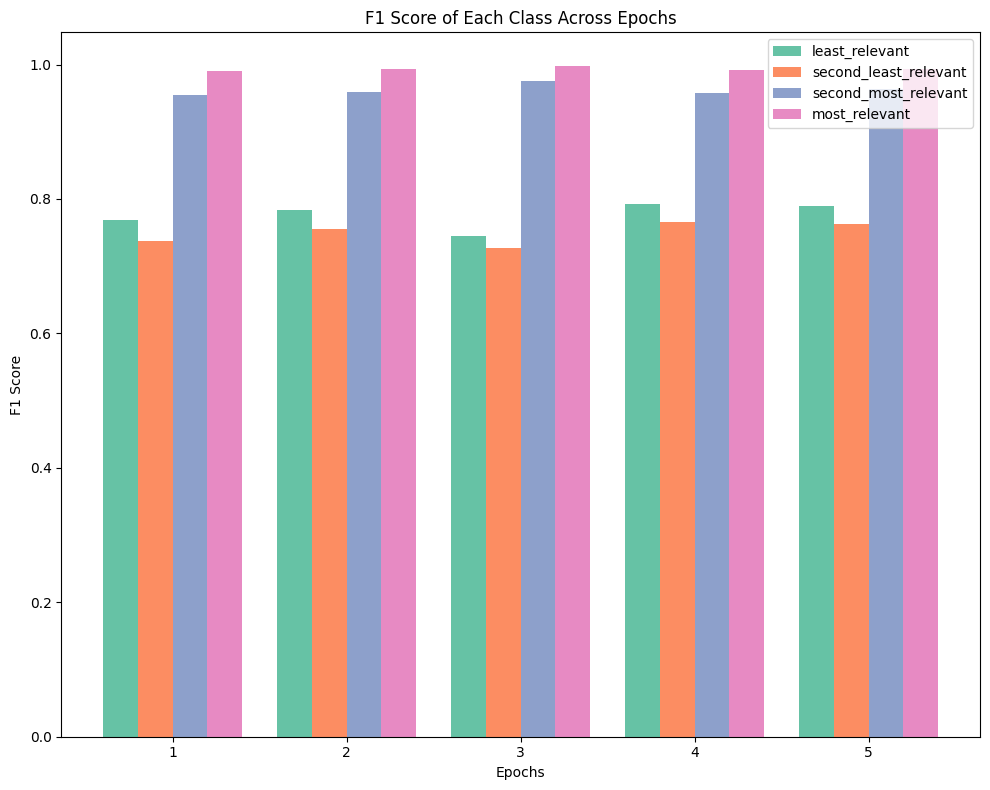

In [28]:
epochs = list(range(1, n_epochs+1))

fig, ax = plt.subplots(figsize=(10, 8))

bar_width = 0.2
index = np.arange(len(epochs))

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

for i, class_name in enumerate(class_names):
    ax.bar(index + i * bar_width, f1_score[class_name], bar_width, label=class_name, color=colors[i])

ax.set_xlabel('Epochs')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score of Each Class Across Epochs')
ax.set_xticks(index + (len(class_names) - 1) * bar_width / 2)
ax.set_xticklabels(epochs)
ax.legend()

plt.tight_layout()
plt.show()

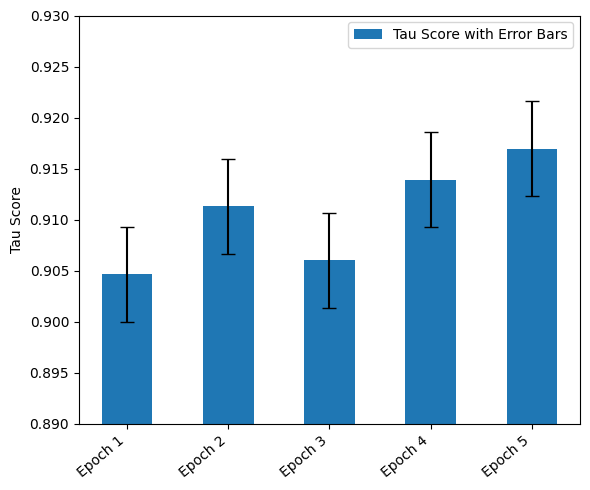

In [37]:
import seaborn as sns

epochs = np.arange(1, n_epochs+1)

bar_positions = np.arange(len(epochs))
epoch_labels = [f"Epoch {epoch}" for epoch in epochs]  # Format labels

tau_std = np.array(tau_score).std()
fig, ax = plt.subplots(figsize=(6, 5))
bar_width = 0.5  # Adjust the width of bars as needed

ax.bar(bar_positions + 0.25 - bar_width/2, tau_score, width=bar_width, yerr=tau_std, capsize=5, label='Tau Score with Error Bars')
ax.set_ylabel('Tau Score')
ax.set_xticks(bar_positions)
ax.set_xticklabels(epoch_labels, rotation=40, ha='right')  # Rotate x-axis labels for better readability
ax.set_ylim([0.89, 0.93])  # Set the maximum limit to 1
ax.legend()
plt.tight_layout()
plt.show()

***
# Score
***

The model’s performance is evaluated using several metrics, including precision, recall, F1-score, and Kendall’s Tau. These metrics provide a comprehensive view of the model’s performance across all classes. Precision measures the model’s exactness, recall measures its completeness, the F1-score balances precision and recall, and Kendall’s Tau measures the correlation between the predicted and actual rankings. 

1.	Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is also known as Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

2.	Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to all the actual positives. It is also known as Sensitivity, Hit Rate, or True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

3.	F1 Score: The F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

4.	Support: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing.

5.	Accuracy: Accuracy is the most intuitive performance measure. It is simply a ratio of correctly predicted observation to the total observations. One may think that if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost the same.

6.	Macro Avg: Macro-average method can be used when you want to know how the model performs overall across the sets of data. You should not come up with any specific decision with this average.

7.	Weighted Avg: In contrary to macro-average method, if you want to know how the model is performing with respect to the most frequent class, you should use a weighted-average method. This will aggregate the contributions of all classes to compute the average metric.

8.	Kendall’s Tau: Kendall’s Tau is a measure of correlation. It gives a value between -1 and 1. A value close to 1 means that there’s a strong positive correlation between the two variables, and a value close to -1 means that there’s a strong negative correlation. A value close to 0 means that there’s no correlation. In your case, the value is approximately 0.70, indicating a good agreement.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [34]:
class Score():

    def __init__(self, data, program):

        self.data = data
        self.program = program

        print("==========================================")
        print("Score")
        print("==========================================")

    def compute_scores(self):
        print("[*] Computing scores")

        y_test = self.program.y_test_truth
        y_test_hat = self.program.y_test_hat

        # Classification report
        print(classification_report(y_test, y_test_hat))

        k_tau, _ = kendalltau(y_test, y_test_hat)
        print(f"Kendall's Tau: {round(k_tau, 3)}")

        kappa = cohen_kappa_score(y_test, y_test_hat)
        print(f"Cohen's Kappa: {round(kappa, 3)}")

In [35]:
# Initialize Score
score = Score(data=data, program=program)

Score


In [36]:
# Compute Score
score.compute_scores()

[*] Computing scores
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79      1000
         1.0       0.76      0.76      0.76      1000
         2.0       0.96      0.96      0.96      1000
         3.0       0.99      0.99      0.99      1000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

Kendall's Tau: 0.917
Cohen's Kappa: 0.836


***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**

In [ ]:
!python $program_dir/ingestion.py

### **Test Scoring Program**

In [ ]:
!python $score_dir/score.py

### **Prepare the submission**

TODOs:  
- The following submission will be submitted by the participants to your competition website. Describe this clearly and point to the competition once your website is ready

In [6]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'Relevance-Baseline1-Sample_Data-Code_Submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `M1-Challenge-Class-2024/Relevance/Starting_Kit/")


Submit : Relevance-Baseline1-Sample_Data-Code_Submission_24-02-13-11-50.zip to the competition
You can find the zip file in `M1-Challenge-Class-2024/Relevance/Starting_Kit/
